In [1]:
import sys
sys.path.append('src/utils')
from PoNQ import PoNQ
import mesh_tools as mt
import torch
from pytorch3d.loss import chamfer_distance
from pytorch3d.ops import knn_points
from meshplot import plot
import matplotlib.pyplot as plt
from tqdm import tqdm
import igl
import numpy as np

In [2]:
model_name = '/data/nmaruani/DATASETS/fun/thai_statue.ply'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
N_PONQ_POINTS = int(5e4)

In [3]:
input_points, input_normals = mt.load_shape(model_name, normalize='NDC', sample_n=int(40*N_PONQ_POINTS))

In [5]:
ponq_points = input_points[np.random.choice(len(input_points), N_PONQ_POINTS)] + 1e-5

In [6]:
V = PoNQ(ponq_points, device)

optimizer = torch.optim.Adam([V.points], 1e-3)

tensor_surface = torch.tensor(input_points, dtype=torch.float32).to(device)
tensor_normals = torch.tensor(input_normals, dtype=torch.float32).to(device)
L=[]


In [7]:
def train_simple(V, optimizer, tensor_surface, repulsion_fac=0, sample_fac=1):
    optimizer.zero_grad()
    masks = torch.rand_like(tensor_surface[:, 0]) < sample_fac
    loss = chamfer_distance(
        tensor_surface[masks][None, :], V.points[None, :])[0].mean()
    if repulsion_fac > 0:
        min_dist = knn_points(V.points[None, :], V.points[None, :], K=2).dists[0, :, 1]**2
        loss += -repulsion_fac * min_dist.mean()
    x = loss.item()
    loss.backward()
    optimizer.step()
    return x


100%|██████████| 200/200 [00:09<00:00, 20.11it/s]


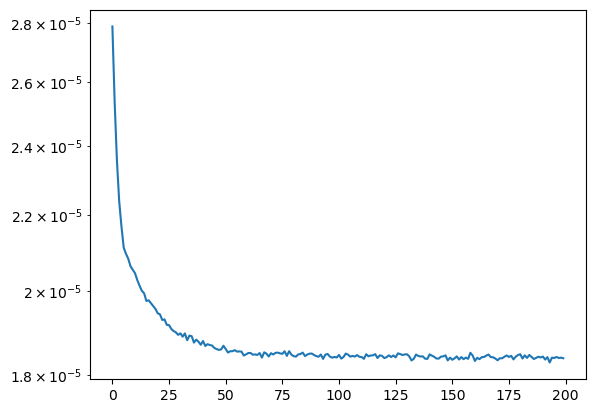

In [8]:
for i in tqdm(range(200)):
    L.append((train_simple(V, optimizer, tensor_surface, repulsion_fac=0, sample_fac=.1)))
plt.plot(L)
plt.yscale('log')

In [9]:
V.cluster_samples_quadrics_normals(tensor_surface, tensor_normals)

In [9]:
# plot(*V.quadric_ellipse_mesh())

In [10]:
nv, nf = V.min_cut_surface(128)

In [11]:
mt.export_obj(nv, nf, 'thai_50k')

In [12]:
torch.save(V, 'thai_50k.pt')

In [13]:
len(V.points), sum(p.numel() for p in [V.points, V.mean_normals, V.quadrics])

(50000, 800000)